# Modeling
### Alex Bass
### 8 Aug 2022  

*Description*: I have already tested out a few models in my previous notebook, but I wanted to redo some and try out the negative binomial regression model. I think it may be more straight forward to interpret and could still work with the imbalance of zeros

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import os
import bambi as bmb

from formulae import design_matrices

In [2]:
data = pd.read_csv('/Users/alex/Library/CloudStorage/OneDrive-Personal/DS6040/Project - School Shootings/Finalized_Data/new_train.csv') #reading in final data
data.columns

Index(['X', 'STATE', 'gun_own', 'hunt_license', 'background_checks',
       'gun_permit_law', 'COUNTY', 'under40', 'Male', 'White', 'Black',
       'Asian', 'Hispanic', 'State', 'CountyName', 'countyFIPS',
       'Unemployment_rate_2021', 'Median_Household_Income_2020', 'ba_plus',
       'less_than_hs', 'hs', 'some_col', 'population', 'n', 'gun_strictness',
       'rural', 'suburban', 'urban'],
      dtype='object')

In [3]:
data.shape

(3142, 28)

In [4]:
data.dropna(inplace = True) #dropping NAs

data['state_r'] = data['STATE']
data = data.replace({'state_r': {1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 8: 5, 9: 6, 10: 7, 12: 8, 13: 9, 15: 10, 16: 11, 17: 12, 18: 13, 
                           19: 14, 20: 15, 21: 16, 22: 17, 23: 18, 24: 19, 25: 20, 26: 21, 27: 22, 28: 23, 29: 24, 30: 25, 
                           31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 
                           44: 38, 45: 39, 46: 40, 47: 41, 48: 42, 49: 43, 50: 44, 51: 45, 53: 46, 54: 47, 55: 48, 56: 49 
}})

state_r = data.state_r.values
n_state = len(data.state_r.unique())

data.state_r.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [5]:
#scaling all data
columns_to_scale = ['gun_own',
       'hunt_license', 'under40', 'Male', 'White', 'Black', 'Asian',
       'Hispanic', 'Unemployment_rate_2021', 'Median_Household_Income_2020',
       'ba_plus', 'less_than_hs', 'hs', 'some_col',
       'population', 'gun_strictness']

data[columns_to_scale] = data[columns_to_scale].apply(lambda x : (x - np.mean(x))/np.std(x))

In [6]:
fml = "n ~ gun_own + background_checks + gun_permit_law + gun_strictness + hunt_license + under40 + Male + White + Black + Asian + Hispanic + Unemployment_rate_2021 + Median_Household_Income_2020 + ba_plus + less_than_hs + hs + some_col + urban + suburban + rural + population"  # full formulae formulation

dm = design_matrices(fml, data, na_action="error")

mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

mx_ex

,Intercept,gun_own,background_checks,gun_permit_law,gun_strictness,hunt_license,under40,Male,White,Black,...,Unemployment_rate_2021,Median_Household_Income_2020,ba_plus,less_than_hs,hs,some_col,urban,suburban,rural,population
0,1.0,0.833042,0.0,0.0,-1.154567,-0.186645,0.397307,-0.717680,-0.495257,0.745100,...,-1.054016,0.694312,0.589642,-0.184500,-0.346835,-0.382626,1.0,0.0,0.0,-0.145751
1,1.0,0.833042,0.0,0.0,-1.154567,-0.186645,-0.419029,-0.718403,0.187723,-0.039755,...,-0.940531,0.939418,0.960109,-0.475586,-0.917436,0.061710,1.0,0.0,0.0,0.355878
2,1.0,0.833042,0.0,0.0,-1.154567,-0.186645,0.204220,1.238609,-2.151528,2.691732,...,0.591523,-1.276080,-1.134098,2.131007,0.245205,-0.690082,0.0,1.0,0.0,-0.239213
3,1.0,0.833042,0.0,0.0,-1.154567,-0.186645,0.386655,1.392354,-0.464478,0.825132,...,-0.656817,-0.449379,-1.161714,1.112068,1.511475,-1.235287,1.0,0.0,0.0,-0.246082
4,1.0,0.833042,0.0,0.0,-1.154567,-0.186645,0.074468,-0.388431,0.699984,-0.530321,...,-1.280987,-0.154428,-0.965131,0.790681,0.158194,0.638844,1.0,0.0,0.0,-0.139885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,1.0,2.206241,0.0,0.0,-2.055884,1.079379,1.234813,0.612461,0.573391,-0.549638,...,0.534781,0.901519,-0.143786,-0.823092,-0.224346,1.501087,0.0,1.0,0.0,-0.186291
3137,1.0,2.206241,0.0,0.0,-2.055884,1.079379,0.661028,0.720313,0.648044,-0.596664,...,-0.827045,2.405455,3.348400,-1.173494,-2.484783,-1.319654,0.0,0.0,1.0,-0.242875
3138,1.0,2.206241,0.0,0.0,-2.055884,1.079379,0.884406,0.190871,0.668374,-0.595385,...,0.194324,0.947039,-0.361401,-0.911429,0.505643,0.988468,0.0,0.0,1.0,-0.252580
3139,1.0,2.206241,0.0,0.0,-2.055884,1.079379,-0.643928,0.290855,0.620004,-0.608385,...,-0.373103,0.074132,0.124250,-0.729335,-0.699993,1.565122,0.0,0.0,1.0,-0.289808


## Poisson Model

In [7]:
quick_prior_change = 5

with pm.Model() as mdl_fish:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=quick_prior_change)
    b1 = pm.Normal("background_checks", mu=0, sigma=quick_prior_change)#pm.Bernoulli("background_checks", p=Bernoulli_prior)
    b2 = pm.Normal("gun_permit_law", mu=0, sigma=quick_prior_change)
    b3 = pm.Normal("under40", mu=0, sigma=quick_prior_change)
    b4 = pm.Normal("Male", mu=0, sigma=quick_prior_change)
    b5 = pm.Normal("White", mu=0, sigma=quick_prior_change)
    b6 = pm.Normal("Black", mu=0, sigma=quick_prior_change)
    b7 = pm.Normal("Asian", mu=0, sigma=quick_prior_change)
    b8 = pm.Normal("Hispanic", mu=0, sigma=quick_prior_change)
    b9 = pm.Normal("Unemployment_rate_2021", mu=0, sigma=quick_prior_change)
    b10 = pm.Normal("Median_Household_Income_2020", mu=0, sigma=quick_prior_change)
    b11 = pm.Normal("ba_plus", mu=0, sigma=quick_prior_change)
    b12 = pm.Normal("less_than_hs", mu=0, sigma=quick_prior_change)
    b13 = pm.Normal("hs", mu=0, sigma=quick_prior_change)
    b14 = pm.Normal("some_col", mu=0, sigma=quick_prior_change)
    b15 = pm.Normal("population", mu=0, sigma=quick_prior_change)
    b16 = pm.Normal("gun_strictness", mu=0, sigma=quick_prior_change)
    b17 = pm.Normal("gun_own", mu=0, sigma=quick_prior_change)
    b18 = pm.Normal("hunt_license", mu=0, sigma=quick_prior_change)
    b19 = pm.Normal("urban", mu=0, sigma=quick_prior_change)
    b20 = pm.Normal("suburban", mu=0, sigma=quick_prior_change)
    b21 = pm.Normal("rural", mu=0, sigma=quick_prior_change)

    # define linear model and exp link function
    theta = (
        b0
        + b1 * mx_ex["background_checks"].values
        + b2 * mx_ex["gun_permit_law"].values
        + b3 * mx_ex["under40"].values
        + b4 * mx_ex["Male"].values
        + b5 * mx_ex["White"].values
        + b6 * mx_ex["Black"].values
        + b7 * mx_ex["Asian"].values
        + b8 * mx_ex["Hispanic"].values
        + b9 * mx_ex["Unemployment_rate_2021"].values
        + b10 * mx_ex["Median_Household_Income_2020"].values
        + b11 * mx_ex["ba_plus"].values
        + b12 * mx_ex["less_than_hs"].values
        + b13 * mx_ex["hs"].values
        + b14 * mx_ex["some_col"].values
        + b15 * mx_ex["population"].values
        + b16 * mx_ex["gun_strictness"].values
        + b17 * mx_ex["gun_own"].values
        + b18 * mx_ex["hunt_license"].values
        + b19 * mx_ex["urban"].values
        + b20 * mx_ex["suburban"].values
        + b21 * mx_ex["rural"].values
    )

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=pm.math.exp(theta), observed=mx_en["n"].values)

In [8]:
with mdl_fish:
    trace_1 = pm.sample(1000, tune=1000, init = 'adapt_diag', target_accept = 0.90)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rural, suburban, urban, hunt_license, gun_own, gun_strictness, population, some_col, hs, less_than_hs, ba_plus, Median_Household_Income_2020, Unemployment_rate_2021, Hispanic, Asian, Black, White, Male, under40, gun_permit_law, background_checks, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10282 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(


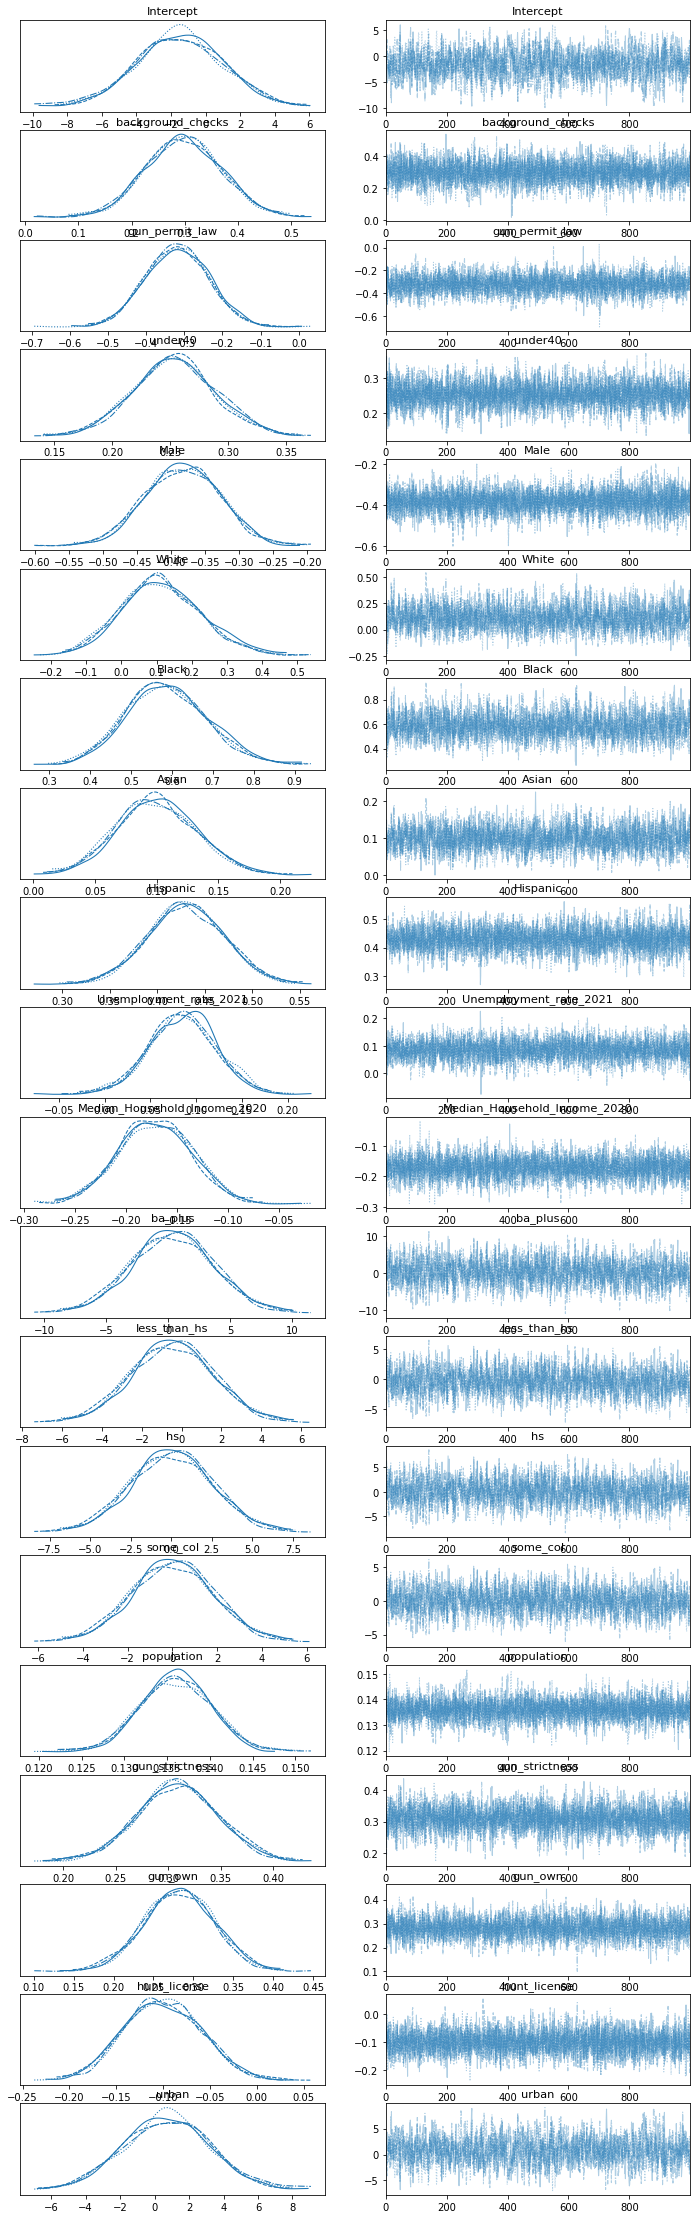

In [9]:
az.plot_trace(trace_1);

In [10]:
az.summary(trace_1, kind="stats") # these need to be exponentiated to be interpretted !!

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
Intercept,-1.515,2.560,-6.351,3.372
background_checks,0.298,0.070,0.168,0.428
gun_permit_law,-0.319,0.081,-0.460,-0.160
under40,0.253,0.035,0.189,0.324
Male,-0.383,0.055,-0.486,-0.281
White,0.113,0.113,-0.103,0.323
Black,0.587,0.099,0.403,0.775
Asian,0.100,0.032,0.040,0.159
Hispanic,0.430,0.040,0.353,0.505
Unemployment_rate_2021,0.085,0.036,0.019,0.154


## Negative Binomial

In [11]:
with pm.Model() as m_neg_binomial:
    
    #Betas
    b = pm.Normal("slopes", mu=0, sigma=5, shape=22)
    
    #Alpha
    alpha = pm.Exponential("alpha", 0.5)
    
    lambd = (
        b[21]
        + b[0] * mx_ex["gun_own"].values
        + b[1] * mx_ex["background_checks"].values
        + b[2] * mx_ex["gun_permit_law"].values
        + b[3] * mx_ex["gun_strictness"].values
        + b[4] * mx_ex["hunt_license"].values
        + b[5] * mx_ex["under40"].values
        + b[6] * mx_ex["Male"].values
        + b[7] * mx_ex["White"].values
        + b[8] * mx_ex["Black"].values
        + b[9] * mx_ex["Asian"].values
        + b[10] * mx_ex["Hispanic"].values
        + b[11] * mx_ex["Unemployment_rate_2021"].values
        + b[12] * mx_ex["Median_Household_Income_2020"].values
        + b[13] * mx_ex["ba_plus"].values
        + b[14] * mx_ex["less_than_hs"].values
        + b[15] * mx_ex["hs"].values
        + b[16] * mx_ex["some_col"].values
        + b[17] * mx_ex["urban"].values
        + b[18] * mx_ex["suburban"].values
        + b[19] * mx_ex["rural"].values
        + b[20] * mx_ex["population"].values
    )

    y = pm.NegativeBinomial("y", mu=pm.math.exp(lambd), alpha=alpha, observed=mx_en["n"])

In [12]:
with m_neg_binomial:
    trace_2 = pm.sample(1000, tune=1000, target_accept = 0.9) #, target_accept = 0.9, init='adapt_diag'

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, slopes]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 875 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'slopes'}>,
        <AxesSubplot:title={'center':'slopes'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

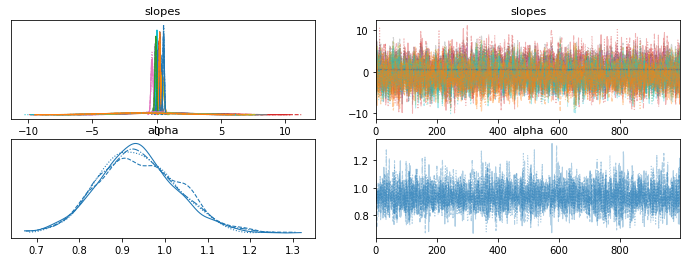

In [13]:
az.plot_trace(trace_2)

In [31]:
az.summary(trace_2, kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
slopes[0],0.305,0.077,0.158,0.448
slopes[1],0.446,0.117,0.235,0.675
slopes[2],-0.006,0.131,-0.242,0.258
slopes[3],0.124,0.066,0.007,0.253
slopes[4],-0.098,0.067,-0.222,0.027
slopes[5],0.233,0.057,0.120,0.339
slopes[6],-0.363,0.080,-0.513,-0.213
slopes[7],0.183,0.138,-0.077,0.448
slopes[8],0.441,0.121,0.228,0.667
slopes[9],0.033,0.054,-0.057,0.144


## Negative Binomial with Random Intercepts

In [15]:
with pm.Model() as m_neg_binomial:
    
    # Random intercepts as offsets
    b0 = pm.Normal('a', mu=0, sd=10, shape=n_state)
    
    #Betas
    b = pm.Normal("slopes", mu=0, sigma=5, shape=21)
    
    #Alpha
    alpha = pm.Exponential("alpha", 0.5)
    
    λ = pm.math.exp(
        b0[state_r]
        + b[0] * mx_ex["gun_own"].values
        + b[1] * mx_ex["background_checks"].values
        + b[2] * mx_ex["gun_permit_law"].values
        + b[3] * mx_ex["gun_strictness"].values
        + b[4] * mx_ex["hunt_license"].values
        + b[5] * mx_ex["under40"].values
        + b[6] * mx_ex["Male"].values
        + b[7] * mx_ex["White"].values
        + b[8] * mx_ex["Black"].values
        + b[9] * mx_ex["Asian"].values
        + b[10] * mx_ex["Hispanic"].values
        + b[11] * mx_ex["Unemployment_rate_2021"].values
        + b[12] * mx_ex["Median_Household_Income_2020"].values
        + b[13] * mx_ex["ba_plus"].values
        + b[14] * mx_ex["less_than_hs"].values
        + b[15] * mx_ex["hs"].values
        + b[16] * mx_ex["some_col"].values
        + b[17] * mx_ex["urban"].values
        + b[18] * mx_ex["suburban"].values
        + b[19] * mx_ex["rural"].values
        + b[20] * mx_ex["population"].values
    )

    y = pm.NegativeBinomial("y", mu=λ, alpha=alpha, observed=mx_en["n"].values)

In [16]:
with m_neg_binomial:
    trace_3 = pm.sample(1000, tune=1000, target_accept = 0.9) #, target_accept = 0.9, init='adapt_diag'

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, slopes, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1617 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'slopes'}>,
        <AxesSubplot:title={'center':'slopes'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

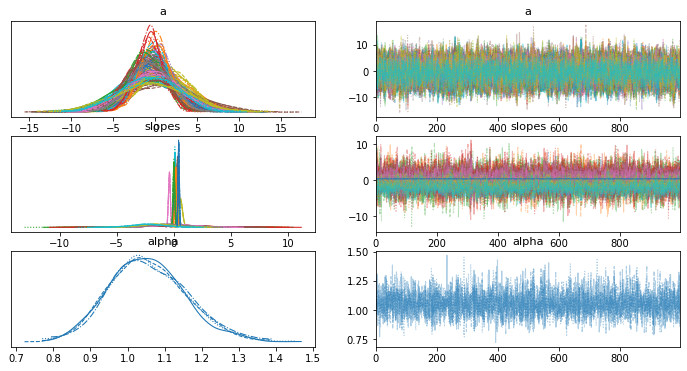

In [17]:
az.plot_trace(trace_3)

In [33]:
az.summary(trace_3, kind="stats").reset_index().to_csv('/Users/alex/Library/CloudStorage/OneDrive-Personal/DS6040/Project - School Shootings/Finalized_Data/final_coef.csv')

np.exp(az.summary(trace_3, kind="stats"))[50:]

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
slopes[0],1.068227,8.109206,0.018316,41.846158
slopes[1],1.038731,20.226629,0.004512,406.262702
slopes[2],0.606531,26.258769,0.002052,395.836006
slopes[3],1.146828,6.104340,0.038083,32.427279
slopes[4],0.993024,5.876727,0.034458,27.303093
slopes[5],1.382647,1.068227,1.218962,1.568312
slopes[6],0.680451,1.084371,0.586255,0.789781
slopes[7],1.294339,1.193631,0.943650,1.822119
slopes[8],1.858928,1.172338,1.392360,2.511801
slopes[9],1.115162,1.062899,0.994018,1.252323


## Model Comparison

In [21]:
df_comp_loo = az.compare({"pooled_poisson_all": trace_1,
                          "pooled_negative_all": trace_2,
                          "Hierarchical_negative" : trace_3
                         })
df_comp_loo

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
Got error No model on context stack. trying to find log

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Hierarchical_negative,0,-2047.275871,73.598152,0.000000,0.410960,70.214382,0.000000,True,log
pooled_negative_all,1,-2051.472702,32.702272,4.196831,0.492345,76.129995,15.605345,True,log
pooled_poisson_all,2,-2596.768309,109.177956,549.492439,0.096695,195.114530,148.950046,True,log


## Predictions with Best Model

In [23]:
summary = az.summary(trace_3)

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [24]:
B_vector = summary[['mean']].T.reset_index(drop=True).iloc[:,:-1]
B_vector

,a[0],a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8],a[9],...,slopes[11],slopes[12],slopes[13],slopes[14],slopes[15],slopes[16],slopes[17],slopes[18],slopes[19],slopes[20]
0,-0.315,0.174,-0.419,-0.358,-0.576,-0.529,0.308,0.306,-0.041,-1.198,...,0.18,0.012,0.123,0.031,-0.205,0.117,-0.547,-1.499,-2.268,0.435


In [25]:
fml = "n ~ C(STATE) + gun_own + background_checks + gun_permit_law + gun_strictness + hunt_license + under40 + Male + White + Black + Asian + Hispanic + Unemployment_rate_2021 + Median_Household_Income_2020 + ba_plus + less_than_hs + hs + some_col + urban + suburban + rural + population"  # full formulae formulation

dm = design_matrices(fml, data, na_action="error")

X = dm.common.as_dataframe()

X

,Intercept,C(STATE)[2],C(STATE)[4],C(STATE)[5],C(STATE)[6],C(STATE)[8],C(STATE)[9],C(STATE)[10],C(STATE)[12],C(STATE)[13],...,Unemployment_rate_2021,Median_Household_Income_2020,ba_plus,less_than_hs,hs,some_col,urban,suburban,rural,population
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.054016,0.694312,0.589642,-0.184500,-0.346835,-0.382626,1.0,0.0,0.0,-0.145751
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.940531,0.939418,0.960109,-0.475586,-0.917436,0.061710,1.0,0.0,0.0,0.355878
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.591523,-1.276080,-1.134098,2.131007,0.245205,-0.690082,0.0,1.0,0.0,-0.239213
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.656817,-0.449379,-1.161714,1.112068,1.511475,-1.235287,1.0,0.0,0.0,-0.246082
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.280987,-0.154428,-0.965131,0.790681,0.158194,0.638844,1.0,0.0,0.0,-0.139885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.534781,0.901519,-0.143786,-0.823092,-0.224346,1.501087,0.0,1.0,0.0,-0.186291
3137,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.827045,2.405455,3.348400,-1.173494,-2.484783,-1.319654,0.0,0.0,1.0,-0.242875
3138,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.194324,0.947039,-0.361401,-0.911429,0.505643,0.988468,0.0,0.0,1.0,-0.252580
3139,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.373103,0.074132,0.124250,-0.729335,-0.699993,1.565122,0.0,0.0,1.0,-0.289808


In [26]:
preds = B_vector.values*X
# preds = np.array(np.exp(preds.iloc[:,:-1].sum(axis=1)[:]))
preds = np.exp(preds.iloc[:,:-1].sum(axis=1)[:])

In [27]:
preds.describe()

count    3141.000000
mean        0.263811
std         0.505446
min         0.000754
25%         0.034657
50%         0.091273
75%         0.281533
max         7.942095
dtype: float64

In [28]:
preds.sort_values(ascending=False)

2293    7.942095
1311    6.859492
1829    6.264591
2505    5.632999
50      5.313616
          ...   
538     0.002967
1758    0.002883
2269    0.002857
249     0.002689
257     0.000754
Length: 3141, dtype: float64

In [29]:
data["preds"] = preds.values
data = data[["countyFIPS","State","STATE","COUNTY","CountyName","preds"]].reset_index()
data.countyFIPS = data.countyFIPS\
    .astype('string')\
    .str\
    .rjust(5, "0")

In [30]:
data.to_csv('/Users/alex/Library/CloudStorage/OneDrive-Personal/DS6040/Project - School Shootings/Finalized_Data/predicted.csv')